#Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile('/content/utkface-new.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

#Data preprocessing

In [2]:
images = []
ages = []
for i in os.listdir('/content/crop_part1')[0:23600]:
    split = i.split('_')
    ages.append(int(split[0]))
    images.append(Image.open('/content/crop_part1/' + i))

In [3]:
df = pd.DataFrame()
df['Images'], df['Ages'] = images, ages
df.head()

,Images,Ages
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,26
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,50
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,2
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,54
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,8


In [4]:
len(df)

9780

<ipython-input-5-e6954b02bec0>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Ages'],kde=True, bins=80)


<Axes: xlabel='Ages', ylabel='Density'>

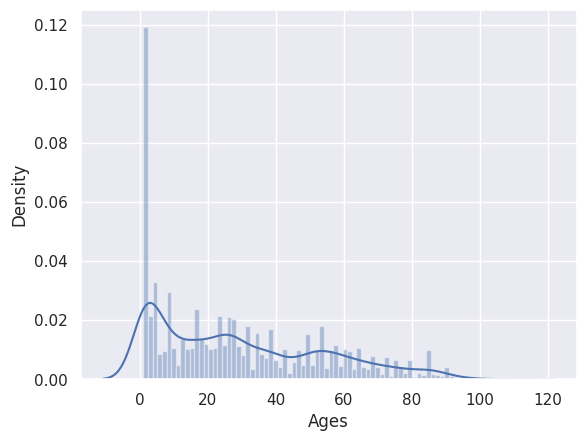

In [5]:
sns.set_theme()
sns.distplot(df['Ages'],kde=True, bins=80)

In [6]:
len(df)

9780

<ipython-input-7-a7a5f7a80614>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Ages'],kde=True, bins=30)


<Axes: xlabel='Ages', ylabel='Density'>

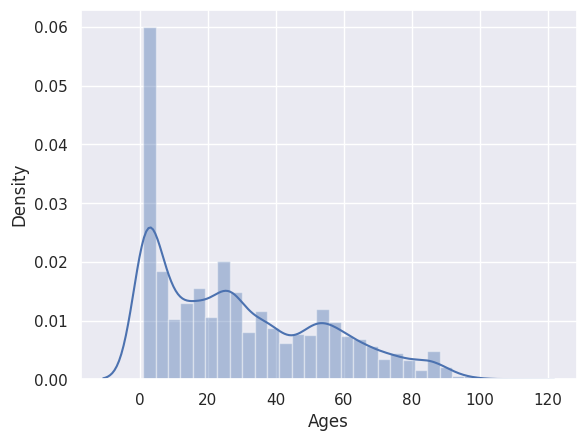

In [7]:
sns.distplot(df['Ages'],kde=True, bins=30)

In [8]:
x = []


for i in range(len(df)):
    df['Images'].iloc[i] = df['Images'].iloc[i].resize((128,128), Image.ANTIALIAS)
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)


x = np.array(x)

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Images'].iloc[i] = df['Images'].iloc[i].resize((128,128), Image.ANTIALIAS)
<ipython-input-8-43bd8384a2cc>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  df['Images'].iloc[i] = df['Images'].iloc[i].resize((128,128), Image.ANTIALIAS)
<ipython-input-8-43bd8384a2cc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Images'].iloc[i] = df['Images'].iloc[i].resize((128,128), Image.ANTIALIAS)
<ipython-input-8-43bd8384a2cc>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZ

In [9]:
x.shape

(9780, 128, 128, 3)

In [10]:
y_age = df['Ages'].values

# Split the data
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(
    x, y_age, test_size=0.2, random_state=42)

In [11]:
x_train_age = np.array(x_train_age)
x_test_age = np.array(x_test_age)
y_train_age = np.array(y_train_age).astype(np.float32)
y_test_age = np.array(y_test_age).astype(np.float32)

#InceptionV3 Pretrained Model

In [13]:
age_model_inception = Sequential()
inception_model_age = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

age_model_inception.add(inception_model_age)
age_model_inception.add(MaxPooling2D())
age_model_inception.add(Flatten())
age_model_inception.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
age_model_inception.add(Dropout(0.1))
age_model_inception.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
age_model_inception.add(Dropout(0.1))
age_model_inception.add(Dense(1, activation='relu'))  # Linear activation for regression

age_model_inception.compile(optimizer=Adam(learning_rate=0.0004), loss='mean_squared_error', metrics=['mae'])

In [14]:
datagen = ImageDataGenerator(
    rescale=1./255., rotation_range=20, width_shift_range=0.1,
    height_shift_range=0.1, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
from keras.callbacks import ModelCheckpoint

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

train_age = datagen.flow(x_train_age, y_train_age, batch_size=16)
test_age = test_datagen.flow(x_test_age, y_test_age, batch_size=16)

history_age_inception = age_model_inception.fit(train_age, epochs=20, shuffle=True, validation_data=test_age, callbacks=callbacks)

Epoch 1/20
489/489 [==============================] - 163s 232ms/step - loss: 227.3128 - mae: 10.5004 - val_loss: 176.8116 - val_mae: 8.9255
Epoch 2/20
489/489 [==============================] - 114s 232ms/step - loss: 151.4047 - mae: 8.5206 - val_loss: 226.2143 - val_mae: 10.5583
Epoch 3/20
489/489 [==============================] - 112s 229ms/step - loss: 113.2727 - mae: 7.2549 - val_loss: 102.4349 - val_mae: 6.7978
Epoch 4/20
489/489 [==============================] - 114s 234ms/step - loss: 105.2623 - mae: 6.9724 - val_loss: 69.6190 - val_mae: 5.7055
Epoch 5/20
489/489 [==============================] - 108s 220ms/step - loss: 99.9222 - mae: 6.8582 - val_loss: 84.9900 - val_mae: 6.5797
Epoch 6/20
489/489 [==============================] - 104s 214ms/step - loss: 86.3208 - mae: 6.3713 - val_loss: 109.7909 - val_mae: 7.7750
Epoch 7/20
489/489 [==============================] - 105s 215ms/step - loss: 92.6359 - mae: 6.4629 - val_loss: 122.0924 - val_mae: 7.3530
Epoch 8/20
489/489 [===

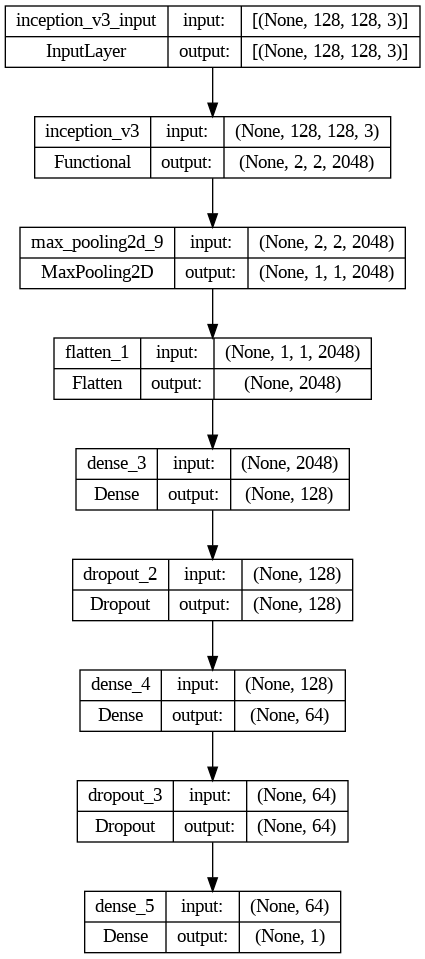

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(age_model_inception, to_file='inceptionv3-model.png', show_shapes=True, show_layer_names=True)

In [25]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

plt.clf()
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history_age_inception.history['mae'],
                    name='Train'))
fig.add_trace(go.Scattergl(
                    y=history_age_inception.history['val_mae'],
                    name='Valid'))
fig.update_layout(height=500,
                  width=700,
                  title='Mean Absolute Error for age feature',
                  xaxis_title='Epoch',
                  yaxis_title='Mean Absolute Error')
fig.show()

<Figure size 640x480 with 0 Axes>

In [26]:
age_model_inception.save('model_pretrain_INCEPTIONV3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

